# WebRender dashboard ETL script

You probably want to look at the [published dashboard](file:///Users/tsmith/projects/webrender-dashboard/dashboard.html).

You can check [scheduled run status](https://dbc-caf9527b-e073.cloud.databricks.com/#job/715).


### What's different?

* Metrics are summarized by build (vs date).
* Performance metrics are aggregated over users; this is important because it reduces the impacts of outlier users on our understanding of product performance, and because it reflects how WebRender changes the user experience at the user level.
* Pings are artisanally hand-selected so that comparisons between experiment branches are fair even in the presence of the various enrollment weirdnesses.

In [2]:
%r
library(boot)
library(dplyr, warn.conflicts=FALSE)
library(ggplot2)
library(sparklyr, warn.conflicts=FALSE)
library(tidyr, warn.conflicts=FALSE)

sc = spark_connect(method="databricks")

# Save result tables so we can access them from hala


In [3]:
from moztelemetry.dataset import Dataset
import pandas as pd
from pyspark.sql import Row
from pyspark.sql import functions as f
from pyspark.sql.types import StructType, StructField, StringType, BooleanType, IntegerType, DoubleType, LongType, MapType
from statsmodels.stats.weightstats import DescrStatsW

EXPERIMENT_ID = "prefflip-webrender-v1-2-1492568"
EXPERIMENT_ID_2 = "prefflip-webrender-v1-3-1492568"
PARTITIONS = [s.replace("-", "_") for s in (EXPERIMENT_ID, EXPERIMENT_ID_2)]

In [4]:
to_summarize = {
  "composite_time": "payload.processes.gpu.histograms.COMPOSITE_TIME",
  "content_frame_time": "payload.processes.gpu.histograms.CONTENT_FRAME_TIME",
  "content_frame_time_vsync": "payload.processes.gpu.histograms.CONTENT_FRAME_TIME_VSYNC",
  "content_frame_time": "payload.processes.gpu.histograms.CONTENT_FRAME_TIME",
  "content_frame_time_svg": "payload.processes.gpu.histograms.CONTENT_FRAME_TIME_WITH_SVG",
  "content_frame_time_reason": "payload.processes.gpu.histograms.CONTENT_FRAME_TIME_REASON",
  "content_frame_time_without_upload": "payload.processes.gpu.histograms.CONTENT_FRAME_TIME_WITHOUT_UPLOAD",
  "content_paint_time": "payload.processes.content.histograms.CONTENT_PAINT_TIME",
  "tab_switch_composite": "payload.histograms.FX_TAB_SWITCH_COMPOSITE_E10S_MS",
  "content_full_paint_time": "payload.processes.gpu.histograms.CONTENT_FULL_PAINT_TIME",
  "page_load_ms": "payload.histograms.FX_PAGE_LOAD_MS_2"
}

to_pull = {}
for k, v in to_summarize.items():
  to_pull[k] = v + ".values"
  to_pull[k + "_sum"] = v + ".sum"

pings = (
  Dataset
  .from_source("telemetry-cohorts")
  .where(
    docType="main",
    experimentId=lambda x: x in PARTITIONS,
    submissionDate=lambda x: int(x) >= 20190105,
  )
  .select(
    app_build_id="application.buildId",
    branch='environment.experiments."%s".branch' % EXPERIMENT_ID,
    branch2='environment.experiments."%s".branch' % EXPERIMENT_ID_2,
    gfx_info='environment.system.gfx',
    gfx_description="environment.system.gfx.adapters[0].description",
    client_id="clientId",
    gfx_compositor="environment.system.gfx.features.compositor",
    normalized_channel="meta.normalizedChannel",
    profile_subsession_counter="payload.info.profileSubsessionCounter",
    session_id="payload.info.sessionId",
    target_pref_value='environment.settings.userPrefs."gfx.webrender.all.qualified"',
    # ---
    device_reset_reason_content="payload.processes.content.histograms.DEVICE_RESET_REASON.values",
    device_reset_reason_gpu="payload.processes.gpu.histograms.DEVICE_RESET_REASON.values",
    device_reset_reason_parent="payload.histograms.DEVICE_RESET_REASON.values",
    subsession_length="payload.info.subsessionLength",
    active_ticks='payload.processes.parent.scalars."browser.engagement.active_ticks"',
    total_uris='payload.processes.parent.scalars."browser.engagement.total_uri_count"',
    **to_pull
  )
  .records(sc)
)

def ping_to_row(x):
  for k, v in to_summarize.items():
    x[k + "_count"] = sum((x[k] or {}).values())
  
  x["experiment"] = (x["branch"] and 2) or 3
  x["branch"] = x["branch"] or x["branch2"]
  del x["branch2"]
  
  # Aggregate DEVICE_RESET_REASON for crash rates
  procs = ("parent", "content", "gpu")
  x["device_reset_reason_total"] = 0
  for proc in procs:
    key = "device_reset_reason_" + proc
    x[key + "_count"] = sum((x[key] or {}).values())
    x["device_reset_reason_total"] += x[key + "_count"]
    del x[key]
  
  # Calculate usage hours for crash rates
  # Based on https://github.com/mozilla/telemetry-streaming/blob/ee2eafd18a8b12a3fafca496d58789f641069bf6/src/main/scala/com/mozilla/telemetry/pings/MainPing.scala#L71-L82
  subsession_length = x["subsession_length"] or 0
  x["usage_hours"] = max(min(subsession_length/3600., 25.), 0.)
  return Row(**x)

fetching 22284.45507MB in 6846 files...

In [5]:
#def 
pings = pings.filter(lambda p: len(p["gfx_info"]["monitors"]) == 1 and p["gfx_info"]["monitors"][0]["refreshRate"] == 60)

In [6]:
sdf_fields = [
  StructField("app_build_id", StringType(), True),
  StructField("branch", StringType(), False),
  StructField("client_id", StringType(), False),
  StructField("experiment", IntegerType(), False),
  StructField("gfx_compositor", StringType(), True),
  StructField("gfx_description", StringType(), True),
  StructField("normalized_channel", StringType(), True),
  StructField("profile_subsession_counter", LongType(), True),  
  StructField("session_id", StringType(), True),
  StructField("target_pref_value", BooleanType(), True),
  StructField("device_reset_reason_parent_count", LongType(), True),
  StructField("device_reset_reason_content_count", LongType(), True),
  StructField("device_reset_reason_gpu_count", LongType(), True),
  StructField("device_reset_reason_total", LongType(), True),
  StructField("active_ticks", LongType(), True),
  StructField("total_uris", LongType(), True),
  StructField("subsession_length", LongType(), True),
  StructField("usage_hours", DoubleType(), True),
]

for k, v in to_summarize.items():
  sdf_fields.extend([
    StructField(k, MapType(StringType(), LongType()), True),
    StructField(k + "_sum", LongType(), True),
    StructField(k + "_count", LongType(), True),
  ])

sdf = spark.createDataFrame(pings.map(ping_to_row), schema=StructType(sdf_fields))

In [7]:
sdf.cache()
None

In [8]:
# Because compositor changes don't take effect until the browser restarts,
# we should discard the enrollment session we observe for each client.
# We'll find those sessions here, and then anti-join against this table later.

first_sessions = (
  sdf
  .orderBy(sdf.experiment, sdf.client_id, sdf.branch, sdf.profile_subsession_counter)
  .groupBy(sdf.experiment, sdf.client_id, sdf.branch)
  .agg(
    f.first(sdf.session_id).alias("session_id"),
  )
)

In [9]:
# Broadcast joins time-out unless the cluster is warm
spark.sql("SET spark.sql.autoBroadcastJoinThreshold = -1")

subsessions = (
  sdf
  .join(first_sessions, on=["experiment", "client_id", "branch", "session_id"], how="left_anti")
  .where(sdf.target_pref_value.isNotNull())
  .where(
    ((sdf.branch == "disabled") & (sdf.gfx_compositor == "d3d11"))
    | ((sdf.branch == "enabled") & (sdf.gfx_compositor == "webrender"))
  )
  .where(
    (sdf.normalized_channel == "beta") | (sdf.normalized_channel == "nightly")
  )
  .cache()
)

In [10]:
subsessions.count()
sorted(subsessions.filter("normalized_channel != 'beta'").select('app_build_id').rdd.map(lambda x: x['app_build_id']).countByValue().items())

Out[ 8 ]: 
[(u'20181018123730', 1),
 (u'20181020102231', 1),
 (u'20181028102553', 12),
 (u'20181101100640', 23),
 (u'20181102100039', 13),
 (u'20181104220100', 10),
 (u'20181108220756', 11),
 (u'20181110100119', 1),
 (u'20181111100236', 7),
 (u'20181112220107', 25),
 (u'20181115100051', 1),
 (u'20181116220054', 1),
 (u'20181118100100', 22),
 (u'20181118220115', 2),
 (u'20181121100034', 1),
 (u'20181121220101', 1),
 (u'20181122100048', 1),
 (u'20181122220059', 8),
 (u'20181123100103', 1),
 (u'20181125100116', 1),
 (u'20181126100057', 1),
 (u'20181126234942', 1),
 (u'20181129095546', 17),
 (u'20181130093534', 11),
 (u'20181201213736', 1),
 (u'20181202094648', 6),
 (u'20181203093109', 56),
 (u'20181203214946', 2),
 (u'20181205102000', 109),
 (u'20181205213623', 41),
 (u'20181206092619', 2),
 (u'20181206214149', 2),
 (u'20181207093029', 37),
 (u'20181208094804', 6),
 (u'20181208213539', 5),
 (u'20181209093514', 21),
 (u'20181209214327', 8),
 (u'20181210095504', 2),
 (u'20181210220553', 2),
 (u'20181211093801', 14),
 (u'20181211213305', 1),
 (u'20181212051241', 1),
 (u'20181212215507', 9),
 (u'20181213094243', 55),
 (u'20181213224257', 1),
 (u'20181214054322', 7),
 (u'20181214220012', 5),
 (u'20181215094001', 43),
 (u'20181215214208', 3),
 (u'20181216181156', 2),
 (u'20181217000148', 3),
 (u'20181217093726', 3),
 (u'20181217220100', 55),
 (u'20181218095120', 12),
 (u'20181218191030', 87),
 (u'20181219094656', 6),
 (u'20181219220049', 10),
 (u'20181220105637', 45),
 (u'20181220215605', 2),
 (u'20181221093752', 9),
 (u'20181221215622', 15),
 (u'20181222095037', 13),
 (u'20181222220504', 22),
 (u'20181223170426', 10),
 (u'20181223215209', 8),
 (u'20181224215145', 12),
 (u'20181225095124', 21),
 (u'20181225215930', 7),
 (u'20181226093642', 148),
 (u'20181226215140', 7),
 (u'20181227092648', 37),
 (u'20181227215704', 54),
 (u'20181228093007', 37),
 (u'20181228215042', 14),
 (u'20181229093614', 59),
 (u'20181229214252', 262),
 (u'20181230093119', 48),
 (u'20181231091417', 76),
 (u'20181231212755', 83),
 (u'20190101094742', 38),
 (u'20190101212914', 56),
 (u'20190102094850', 166),
 (u'20190102213721', 199),
 (u'20190103094209', 474),
 (u'20190103220533', 12399),
 (u'20190104093221', 487),
 (u'20190104132412', 434),
 (u'20190104214806', 1567),
 (u'20190105123739', 1081),
 (u'20190105215256', 1098),
 (u'20190106095006', 1625),
 (u'20190106214444', 1099),
 (u'20190107093040', 1561),
 (u'20190107214730', 843),
 (u'20190108101613', 2405),
 (u'20190108215840', 2889),
 (u'20190109092644', 2218),
 (u'20190109163702', 1235),
 (u'20190109214248', 2558),
 (u'20190110093854', 3773),
 (u'20190110214210', 1723),
 (u'20190111093148', 3074),
 (u'20190111215452', 2372),
 (u'20190112094119', 2962),
 (u'20190112213654', 2400),
 (u'20190113100555', 2314),
 (u'20190113213646', 431),
 (u'20190114014511', 897),
 (u'20190114104248', 113)]

In [11]:
subsessions.createOrReplaceGlobalTempView("webrender_metrics")

In [12]:
# Compute per-user quantiles for CONTENT_PAINT_TIME

def generate_quantile_udf(sdf, grouping_fields, bucket_field, count_field, quantiles):
  """
  sdf: Spark DataFrame
  grouping_fields: list of strings representing columns from sdf
  bucket_field: Name of the field containing histogram buckets
  count_field: Name of the field containing counts
  quantiles: List of quantiles as floating point values on [0, 1]
  """
  schema = (
    sdf
    .select(*grouping_fields)
    .schema
    .add(StructField("quantile", DoubleType(), False))
    .add(StructField("value", DoubleType(), True))
  )
  
  @f.pandas_udf(schema, f.PandasUDFType.GROUPED_MAP)
  def udf(df):
    stats = DescrStatsW(df[bucket_field].astype(float), df[count_field]).quantile(quantiles)
    stats = stats.rename_axis("quantile").reset_index(name="value").assign(_dummy=1)
    grouping_variables = df[grouping_fields].iloc[:1].assign(_dummy=1)
    result = grouping_variables.merge(stats, on="_dummy").drop("_dummy", axis=1)
    return result
  
  return udf

metric_quantiles = generate_quantile_udf(
  subsessions,
  ["client_id", "branch", "app_build_id", "normalized_channel"],
  bucket_field="bucket",
  count_field="count",
  quantiles=[0.5, 0.9, 0.95, 0.99]
)

paint_time_quantiles = (
  subsessions
  .select(
    subsessions.client_id,
    subsessions.branch,
    subsessions.normalized_channel,
    subsessions.app_build_id,
    f.explode(subsessions.content_paint_time).alias("bucket", "count")
  )
  .groupBy(subsessions.client_id, subsessions.branch, subsessions.app_build_id, subsessions.normalized_channel, "bucket")
  .agg(f.sum("count").alias("count"))
  .groupBy(subsessions.client_id, subsessions.branch, subsessions.app_build_id, subsessions.normalized_channel)
  .apply(metric_quantiles)
)

paint_time_quantiles.createOrReplaceGlobalTempView("wr_paint_time_quantiles")

In [13]:
  schema = (
    sdf
    .select(*["client_id", "app_build_id", "normalized_channel", "branch"])
    .schema
    #.add(StructField("branch", StringType(), False))
    .add(StructField("threshold", IntegerType(), False))
    .add(StructField("fraction_exceeding", DoubleType(), True))
  )
  
  schema2 = (
    sdf
    .select(*["client_id", "app_build_id", "normalized_channel"])
    .schema
    .add(StructField("branch", StringType(), False))
    .add(StructField("threshold", IntegerType(), False))
    .add(StructField("fraction_exceeding", DoubleType(), True))
  )
  schema == schema2

Out[ 11 ]: True

In [14]:
# Changes to CONTENT_FRAME_TIME are only user-visible when CONTENT_FRAME_TIME exceeds 200.
# Count the fraction of CONTENT_FRAME_TIME events where the threshold is exceeded.
# (The threshold is set to 192 because of the binning of the histogram.)

def generate_threshold_udf(sdf, grouping_fields, bucket_field, count_field, thresholds):
  """
  sdf: Spark DataFrame
  grouping_fields: list of strings representing columns from sdf
  bucket_field: Name of the field containing histogram buckets
  count_field: Name of the field containing counts
  thresholds: List of thresholds. Should probably align on the left edge of a bucket.
  """
  schema = (
    sdf
    .select(*grouping_fields)
    .schema
    .add(StructField("branch", StringType(), False))
    .add(StructField("threshold", IntegerType(), False))
    .add(StructField("fraction_exceeding", DoubleType(), True))
  )
  
  @f.pandas_udf(schema, f.PandasUDFType.GROUPED_MAP)
  def udf(df):
    rows = []
    all_sum = float(df[count_field].sum())
    for tx in thresholds:
      fraction = df.loc[df[bucket_field].astype(int) >= tx, count_field].sum() / all_sum
      rows.append({"threshold": tx, "fraction_exceeding": fraction})
    data = pd.DataFrame(rows).assign(_dummy=1)
    grouping_variables = df[["client_id", "app_build_id", "normalized_channel", "branch"]].iloc[:1].assign(_dummy=1)
    result = grouping_variables.merge(data, on="_dummy").drop("_dummy", axis=1)
    return result
  
  return udf

vsync_threshold = generate_threshold_udf(
  subsessions,
  ["client_id", "app_build_id", "normalized_channel"],
  bucket_field="bucket",
  count_field="count",
  thresholds=[192],
)

slow_content_frame_time = (
  subsessions
  .select(
    subsessions.client_id,
    "branch",
    subsessions.normalized_channel,
    subsessions.app_build_id,
    f.explode(subsessions.content_frame_time).alias("bucket", "count")
  )
  .groupBy(subsessions.client_id, "branch", subsessions.app_build_id, subsessions.normalized_channel)
  .apply(vsync_threshold)
)

slow_content_frame_time.createOrReplaceGlobalTempView("wr_slow_content_frame_time")

In [15]:
# Changes to CONTENT_FRAME_TIME are only user-visible when CONTENT_FRAME_TIME exceeds 200.
# Count the fraction of CONTENT_FRAME_TIME events where the threshold is exceeded.
# (The threshold is set to 192 because of the binning of the histogram.)

def subtract_svg(branch, x, y):
  if x and y:
    no_svg = dict(x)
    #assert(branch == "enabled")
    for k in y.keys():
      if k in no_svg:
        no_svg[k] -= y[k]
    return {branch:x, branch + "nosvg": no_svg};
  return {branch: x}

frame_time = udf(subtract_svg, MapType(StringType(), MapType(StringType(), IntegerType(), True), True))


slow_content_frame_time_svg = (
  subsessions
  .filter("app_build_id >= '20190107214730'")
  #.filter("branch == 'enabled'")
  .select(
    subsessions.client_id,
    subsessions.normalized_channel,
    subsessions.app_build_id,
    f.explode(frame_time("branch", subsessions.content_frame_time_vsync, subsessions.content_frame_time_svg)).alias("branch", "timing")
  )
  .select(
    subsessions.client_id,
    "branch",
    subsessions.normalized_channel,
    subsessions.app_build_id,
    f.explode("timing").alias("bucket", "count"),
  )
  .groupBy(subsessions.client_id, "branch", subsessions.app_build_id, subsessions.normalized_channel)
  .apply(vsync_threshold)
)
#slow_content_frame_time_svg.take(1)
#slow_content_frame_time_svg.filter("branch != 'enabled'").take(100)
#help(slow_content_frame_time)

slow_content_frame_time_svg.createOrReplaceGlobalTempView("wr_slow_content_frame_time_svg")
#slow_content_frame_time_svg.filter("branch != 'enabled'").take(100)

In [16]:
# Changes to CONTENT_FRAME_TIME are only user-visible when CONTENT_FRAME_TIME exceeds 200.
# Count the fraction of CONTENT_FRAME_TIME events where the threshold is exceeded.
# (The threshold is set to 192 because of the binning of the histogram.)

def no_upload(branch, x, y):
  if x and y:
    return {branch:x, branch + "noupload": y};
  return {branch: x}

frame_time = udf(no_upload, MapType(StringType(), MapType(StringType(), IntegerType(), True), True))


slow_content_frame_time_without_upload = (
  subsessions
  .filter("app_build_id >= '20190107214730'")
  #.filter("branch == 'enabled'")
  .select(
    subsessions.client_id,
    subsessions.normalized_channel,
    subsessions.app_build_id,
    f.explode(frame_time("branch", subsessions.content_frame_time_vsync, subsessions.content_frame_time_without_upload)).alias("branch", "timing")
  )
  .select(
    subsessions.client_id,
    "branch",
    subsessions.normalized_channel,
    subsessions.app_build_id,
    f.explode("timing").alias("bucket", "count"),
  )
  .groupBy(subsessions.client_id, "branch", subsessions.app_build_id, subsessions.normalized_channel)
  .apply(vsync_threshold)
)
#slow_content_frame_time_without_upload.take(1)
#slow_content_frame_time_svg.filter("branch != 'enabled'").take(100)
#help(slow_content_frame_time)

slow_content_frame_time_without_upload.createOrReplaceGlobalTempView("wr_slow_content_frame_time_without_upload")

In [17]:
def countBadPaints(x):
  reasonPaints = 0
  timePaints = 0
  for (k, v) in x['content_frame_time_reason'].iteritems():
    if k != '0':
      reasonPaints += v
  for (k, v) in x['content_frame_time'].iteritems():
    if int(k) >= 192:
      timePaints += v
  return (reasonPaints, timePaints)

#subsessions.filter("normalized_channel != 'beta'").filter("app_build_id == '20181222095037'").filter("branch = 'enabled'").rdd.filter(lambda x:  #x['content_frame_time_reason']).map(countBadPaints).take(8)

In [18]:
#subsessions.select("app_build_id").groupBy("app_build_id").count().sort("app_build_id").take(400)

In [19]:
individual_paints = (subsessions.filter("normalized_channel != 'beta'")
  #.filter("branch = 'enabled'")
  .filter("app_build_id == '20190107214730'") # reasons on non-wr
  .select('content_frame_time_vsync','content_frame_time_vsync_count', 'branch', 'content_frame_time_reason', 'content_frame_time_reason_count'))
def reduce_ping(x):
  above = 0
  if not x['content_frame_time_reason_count']:
    return 0
  for (key, val) in x['content_frame_time_vsync'].items():
    if int(key) < 200:
      above += val
  frac = above*1. #/ x['content_frame_time_vsync_count']
  l = sorted([(int(key), val) for (key, val) in x['content_frame_time_vsync'].items()])
  #return x['content_frame_time_vsync_count'], x['content_frame_time_reason_count'], x['branch']
  return frac, x['content_frame_time_reason']['0'] *1.# / x['content_frame_time_reason_count']

individual_paints.filter("branch = 'enabled'").rdd.map(reduce_ping).take(15)

Out[ 17 ]: 
[(181.0, 181.0),
 0,
 (1200.0, 1200.0),
 (21.0, 21.0),
 (7901.0, 7901.0),
 (8670.0, 8670.0),
 (5733.0, 5733.0),
 (4957.0, 4957.0),
 (323.0, 323.0),
 (498.0, 498.0),
 (222.0, 222.0),
 (911.0, 911.0),
 (567.0, 567.0),
 (33.0, 33.0),
 (860.0, 860.0)]

In [20]:
all_paints = (subsessions.filter("normalized_channel != 'beta'")
  #.filter("branch = 'enabled'")
  .filter("app_build_id == '20190107214730'") # reasons on non-wr

  .select(f.explode('content_frame_time_vsync').alias("bucket", "count"), 'app_build_id', 'branch')

  .groupBy("app_build_id", "branch", "bucket").agg(
    f.sum("count").alias("count"),
  )
  #.filter("app_build_id >= '20190101000000'")
  #.filter("app_build_id == '20190106095006'") # reasons adjusted

 )
all_paints.count()
enabled = all_paints.filter("branch = 'enabled'").collect()
disabled = all_paints.filter("branch = 'disabled'").collect()
def compute_fraction(x):
  all = 0
  above = 0
  for row in x:
    all += row['count']
    if int(row['bucket']) >= 200:
      above += row['count']
  return above*1./ all
compute_fraction(disabled)*100, compute_fraction(enabled)*100, 

Out[ 18 ]: (3.105576767860492, 7.378489796722368)

In [21]:
reasons = ["OnTime", "NoVsync", "MissedComposite", "SlowComposite", "MissedCompositeMid", "MissedCompositeLong", "MissedCompositeLow", "NA"];
reasons_summary = ["OnTime", "NoVsync", "MissedComposite", "SlowComposite", "MissedComposite", "MissedComposite", "MissedComposite", "NA"];
reason_name = udf(lambda x: reasons[int(x)], StringType())

reasons = (subsessions.filter("normalized_channel != 'beta'")
  #.filter("branch = 'enabled'")
  .select(f.explode('content_frame_time_reason').alias("reason", "count"), 'app_build_id', 'branch')
  .select("count",'app_build_id','branch', reason_name("reason").alias("reason"))

  .groupBy("app_build_id", "branch", "reason").agg(
    f.sum("count").alias("count"),
  )
  #.filter("reason != 'OnTime'")
  #.filter("app_build_id >= '20190101000000'")
  #.filter("app_build_id == '20190106095006'") # reasons adjusted
  .filter("app_build_id >= '20190107214730'") # reasons on non-wr

 )
reasons.cache()
reasons.createOrReplaceGlobalTempView("wr_reasons")

In [22]:
reasons.count()
enabled = reasons.filter("branch = 'enabled'").collect()
disabled = reasons.filter("branch = 'disabled'").collect()
def compute_fraction(x):
  all = 0
  above = 0
  for row in x:
    all += row['count']
    if row['reason'] != 'OnTime':
      above += row['count']
  return above*1./ all
compute_fraction(enabled), compute_fraction(disabled)

Out[ 20 ]: (0.06308266513331773, 0.04983626017535754)

In [23]:
reason_names = ["OnTime", "NoVsync", "MissedComposite", "SlowComposite", "MissedCompositeMid", "MissedCompositeLong", "MissedCompositeLow", "NA"];

def intkeys(x):
  return {int(key):value for (key,value) in x.items()}

def majority(x):
  ctfr = x['content_frame_time_reason']
  if not ctfr:
    return (0, 0)
  slow = 0
  if '3' in ctfr:
    slow += ctfr['3']
  missed = 0
  for i in ctfr.iteritems():
    if i[0] in ('2', '4', '5', '6'):
      missed += i[1]
  return (slow, missed, {reason_names[int(key)]:value for (key, value) in ctfr.items()}, intkeys(x['content_frame_time']), x['gfx_description'], intkeys(x['content_full_paint_time']))

map(majority, subsessions.filter("normalized_channel != 'beta'").select('content_frame_time_reason', 'content_full_paint_time', 'content_frame_time', 'gfx_description').filter("app_build_id == '20181224215145'").rdd.take(100))

Out[ 21 ]: 
[(4,
 2,
 {'MissedComposite': 1,
 'MissedCompositeLong': 0,
 'MissedCompositeMid': 1,
 'OnTime': 308,
 'SlowComposite': 4},
 {11: 0,
 13: 1,
 15: 2,
 18: 3,
 21: 1,
 25: 1,
 34: 1,
 40: 2,
 47: 4,
 55: 4,
 64: 7,
 75: 11,
 88: 7,
 103: 200,
 120: 40,
 140: 13,
 164: 9,
 192: 2,
 224: 1,
 262: 3,
 2688: 2,
 3139: 0},
 u'NVIDIA GeForce GTX 960',
 {0: 18,
 1: 354,
 2: 162,
 3: 37,
 4: 22,
 5: 9,
 6: 4,
 7: 8,
 8: 10,
 9: 4,
 12: 6,
 16: 2,
 42: 1,
 47: 0}),
 (138,
 467,
 {'MissedComposite': 3,
 'MissedCompositeLong': 245,
 'MissedCompositeLow': 20,
 'MissedCompositeMid': 199,
 'NA': 0,
 'NoVsync': 110,
 'OnTime': 9154,
 'SlowComposite': 138},
 {18: 0,
 21: 5,
 25: 6,
 29: 19,
 34: 55,
 40: 107,
 47: 245,
 55: 344,
 64: 449,
 75: 493,
 88: 635,
 103: 2368,
 120: 2926,
 140: 906,
 164: 411,
 192: 316,
 224: 235,
 262: 116,
 306: 73,
 357: 36,
 417: 42,
 487: 20,
 569: 18,
 665: 9,
 777: 5,
 907: 9,
 1059: 6,
 1237: 6,
 1445: 2,
 1688: 3,
 1971: 1,
 2302: 1,
 3139: 1,
 3666: 1,
 4281: 0},
 u'NVIDIA GeForce GTX 1060 6GB',
 {0: 9,
 1: 598,
 2: 1784,
 3: 2060,
 4: 2040,
 5: 1717,
 6: 1446,
 7: 1118,
 8: 856,
 9: 740,
 10: 571,
 11: 406,
 12: 537,
 14: 310,
 16: 222,
 18: 128,
 20: 151,
 23: 66,
 26: 65,
 29: 40,
 33: 39,
 37: 17,
 42: 14,
 47: 10,
 53: 9,
 60: 7,
 67: 7,
 75: 3,
 84: 3,
 135: 1,
 152: 0}),
 (1,
 0,
 {'MissedCompositeMid': 0, 'OnTime': 8, 'SlowComposite': 1},
 {47: 0, 55: 1, 103: 2, 140: 1, 164: 4, 262: 1, 306: 0},
 u'NVIDIA GeForce GTX 1060 6GB',
 {0: 0,
 1: 20,
 2: 7,
 3: 3,
 4: 1,
 5: 2,
 7: 2,
 8: 2,
 9: 2,
 11: 1,
 23: 1,
 26: 0}),
 (14,
 30,
 {'MissedComposite': 2,
 'MissedCompositeLong': 14,
 'MissedCompositeLow': 1,
 'MissedCompositeMid': 13,
 'NA': 0,
 'NoVsync': 9,
 'OnTime': 847,
 'SlowComposite': 14},
 {18: 0,
 21: 1,
 25: 1,
 29: 4,
 34: 8,
 40: 13,
 47: 12,
 55: 15,
 64: 16,
 75: 34,
 88: 60,
 103: 366,
 120: 229,
 140: 58,
 164: 22,
 192: 13,
 224: 18,
 262: 8,
 306: 1,
 357: 2,
 417: 2,
 487: 4,
 1059: 1,
 1237: 1,
 1445: 3,
 2302: 2,
 3139: 2,
 3666: 1,
 4281: 3,
 5000: 0},
 u'NVIDIA GeForce GTX 1060 6GB',
 {0: 7,
 1: 73,
 2: 154,
 3: 180,
 4: 186,
 5: 140,
 6: 108,
 7: 88,
 8: 54,
 9: 41,
 10: 18,
 11: 23,
 12: 25,
 14: 15,
 16: 7,
 18: 12,
 20: 8,
 23: 6,
 26: 7,
 29: 3,
 37: 1,
 42: 1,
 47: 1,
 192: 1,
 216: 0}),
 (1,
 8,
 {'MissedComposite': 8,
 'MissedCompositeMid': 0,
 'NoVsync': 2,
 'OnTime': 16,
 'SlowComposite': 1},
 {3: 0,
 4: 1,
 8: 1,
 13: 1,
 18: 1,
 47: 1,
 64: 2,
 88: 5,
 103: 2,
 120: 1,
 164: 1,
 192: 2,
 224: 1,
 357: 1,
 417: 1,
 569: 1,
 5000: 5},
 u'NVIDIA GeForce GT 220 ',
 {0: 4,
 1: 7,
 2: 4,
 3: 1,
 4: 1,
 5: 1,
 7: 1,
 29: 1,
 33: 1,
 60: 2,
 75: 1,
 1000: 4}),
 (0,
 8,
 {'MissedComposite': 8, 'NoVsync': 3, 'OnTime': 56, 'SlowComposite': 0},
 {2: 0,
 3: 1,
 21: 1,
 25: 1,
 55: 2,
 64: 1,
 75: 9,
 88: 16,
 103: 9,
 120: 5,
 140: 4,
 164: 6,
 192: 3,
 224: 3,
 262: 1,
 357: 1,
 487: 2,
 777: 1,
 1059: 1,
 1237: 0},
 u'NVIDIA GeForce GTX 970',
 {0: 2,
 1: 14,
 2: 2,
 3: 1,
 4: 1,
 5: 2,
 6: 4,
 7: 6,
 8: 2,
 9: 3,
 10: 3,
 11: 3,
 12: 6,
 14: 2,
 16: 2,
 20: 3,
 23: 2,
 26: 2,
 29: 2,
 33: 1,
 37: 3,
 47: 1,
 60: 1,
 75: 1,
 120: 1,
 152: 1,
 171: 0}),
 (8,
 58,
 {'MissedComposite': 1,
 'MissedCompositeLong': 7,
 'MissedCompositeLow': 1,
 'MissedCompositeMid': 49,
 'NA': 0,
 'NoVsync': 4,
 'OnTime': 2109,
 'SlowComposite': 8},
 {8: 0,
 9: 1,
 25: 2,
 29: 1,
 34: 9,
 40: 5,
 47: 8,
 55: 14,
 64: 43,
 75: 45,
 88: 125,
 103: 604,
 120: 1094,
 140: 123,
 164: 23,
 192: 36,
 224: 29,
 262: 5,
 306: 2,
 357: 1,
 487: 1,
 569: 2,
 665: 2,
 907: 1,
 2688: 1,
 3666: 2,
 4281: 0},
 u'NVIDIA GeForce GTX 650',
 {0: 21,
 1: 235,
 2: 526,
 3: 495,
 4: 389,
 5: 269,
 6: 380,
 7: 298,
 8: 529,
 9: 93,
 10: 67,
 11: 24,
 12: 43,
 14: 51,
 16: 70,
 18: 11,
 20: 6,
 23: 3,
 29: 3,
 33: 2,
 37: 0}),
 (0, 0),
 (0,
 2,
 {'MissedComposite': 1,
 'MissedCompositeLong': 1,
 'MissedCompositeLow': 0,
 'NoVsync': 1,
 'OnTime': 115},
 {21: 0,
 25: 1,
 34: 1,
 47: 1,
 75: 1,
 88: 6,
 103: 91,
 120:

In [24]:
#reasons.take(5)

In [25]:
%r
reasons = tbl(sc, "global_temp.wr_reasons")
reasons$reason

NULL

In [26]:
%r
options(repr.plot.height=800)

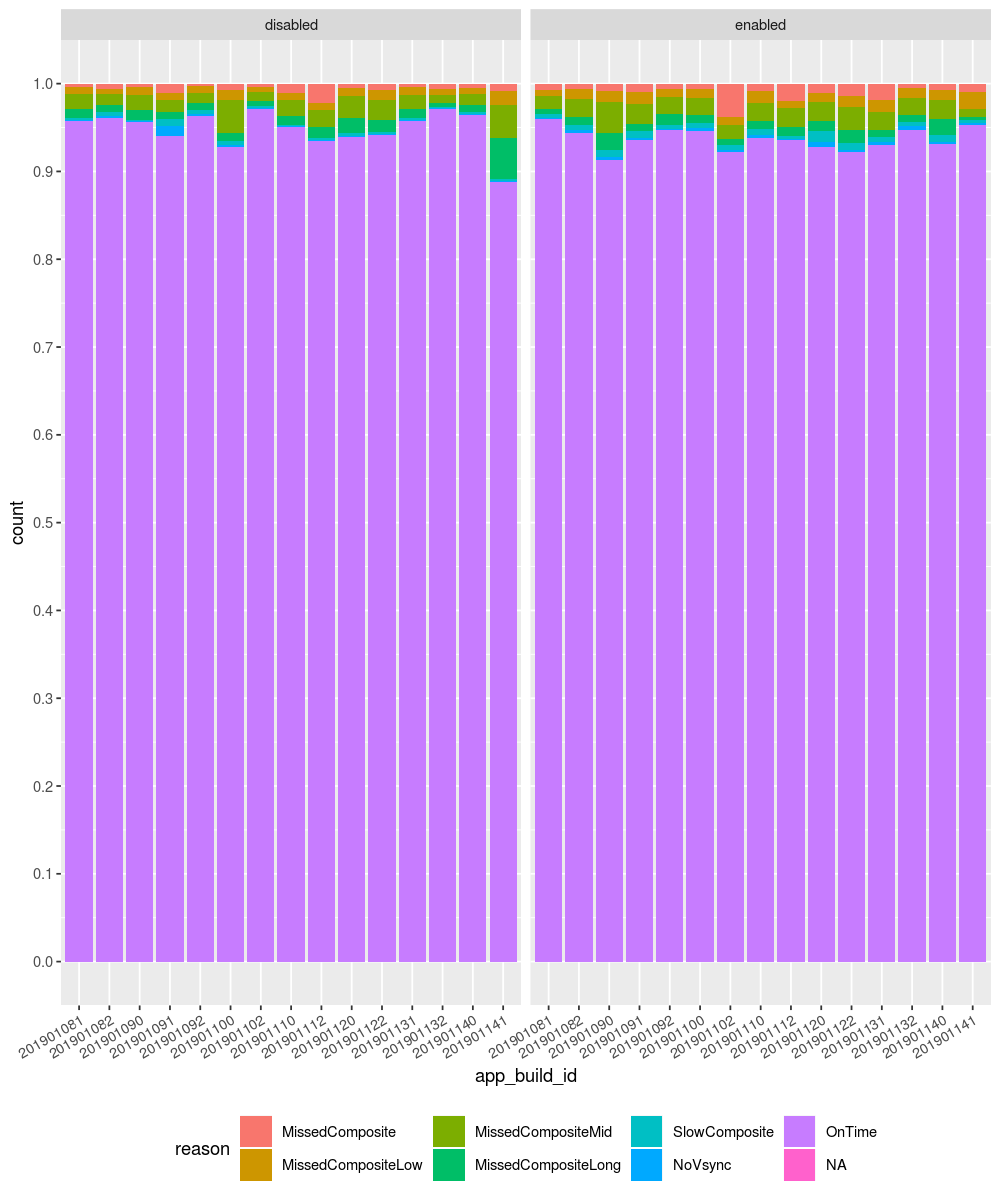

In [27]:
%r
options(repr.plot.height=1200)
p <- reasons %>% 
   filter(app_build_id > "20190107214730") %>%
   mutate(app_build_id=substr(app_build_id, 0,8)) %>%
   ggplot(aes(app_build_id, count, fill=factor(reason, levels=c("MissedComposite", "MissedCompositeLow", "MissedCompositeMid", "MissedCompositeLong", "SlowComposite", "NoVsync",  "OnTime", "NA"))))+
    geom_col(position=position_fill()) +
    scale_fill_discrete("reason") +
    facet_grid(~branch, scales="free_x", space="free_x") +
    theme(axis.text.x=element_text(angle=30, hjust=1)) +  theme(legend.position="bottom") + scale_y_continuous(breaks = scales::pretty_breaks(n = 10))

p

In [28]:
recent = reasons.filter("app_build_id == '20181224215145'").rdd
total = recent.map(lambda x: x['count']).sum()
recent.map(lambda x: (x['reason'], 100.*x['count']/total)).take(300)


Out[ 23 ]: []

In [29]:
# Summarize instances of other performance metrics exceeding 16ms

# to_summarize = {
#   "composite_time": "payload.processes.gpu.histograms.COMPOSITE_TIME",f
#   "content_paint_time": "payload.processes.content.histograms.CONTENT_PAINT_TIME",
#   "content_full_paint_time": "payload.processes.gpu.histograms.CONTENT_FULL_PAINT_TIME",
# }

time_threshold = generate_threshold_udf(
  subsessions,
  ["client_id", "branch", "app_build_id", "normalized_channel"],
  bucket_field="bucket",
  count_field="count",
  thresholds=[16],
)

time_threshold_histograms = ["composite_time", "content_paint_time", "content_full_paint_time"]
for h in time_threshold_histograms:
  slow_df = (
    subsessions
    .select(
      subsessions.client_id,
      subsessions.branch,
      subsessions.normalized_channel,
      subsessions.app_build_id,
      f.explode(h).alias("bucket", "count")
    )
    .groupBy(subsessions.client_id, subsessions.branch, subsessions.app_build_id, subsessions.normalized_channel)
    .apply(time_threshold)
  )
  slow_df.createOrReplaceGlobalTempView("wr_slow_%s" % h)

In [30]:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      crash_pings = (
  Dataset
  .from_source("telemetry-cohorts")
  .where(
    docType="crash",
    experimentId=lambda x: x in PARTITIONS,
  )
  .select(
    app_build_id="application.buildId",
    branch='environment.experiments."%s".branch' % EXPERIMENT_ID,
    branch2='environment.experiments."%s".branch' % EXPERIMENT_ID_2,
    client_id="clientId",
    gfx_compositor="environment.system.gfx.features.compositor",
    ipc_channel_error="payload.metadata.ipc_channel_error",
    normalized_channel="meta.normalizedChannel",
    oom_allocation_size="payload.metadata.OOMAllocationSize",
    process="payload.processType",
    session_id="payload.sessionId",
    target_pref_value='environment.settings.userPrefs."gfx.webrender.all.qualified"',
  )
  .records(sc)
)
                                      
def crash_ping_to_row(x):
  x["experiment"] = (x["branch"] and 2) or 3
  x["branch"] = x["branch"] or x["branch2"]
  del x["branch2"]
  x["is_shutdown_crash"] = x["ipc_channel_error"] == "ShutDownKill"
  x["is_oom_crash"] = x["oom_allocation_size"] is not None
  return Row(**x)

fetching 480.73884MB in 30359 files...

In [31]:
                                                                                                                                                                                                # Some of these fields are frequently null, so sampling the first 100 rows doesn't work reliably,
# and setting a sampling fraction is slow and still flaky, so declare an explicit schema...
crashes = spark.createDataFrame(crash_pings.map(crash_ping_to_row), StructType([
  StructField("client_id", StringType(), False),
  StructField("experiment", IntegerType(), False),
  StructField("branch", StringType(), False),
  StructField("app_build_id", StringType(), True),
  StructField("session_id", StringType(), True),
  StructField("target_pref_value", StringType(), True),
  StructField("gfx_compositor", StringType(), True),
  StructField("normalized_channel", StringType(), True),
  StructField("process", StringType(), True),
  StructField("ipc_channel_error", StringType(), True),
  StructField("oom_allocation_size", StringType(), True),
  StructField("is_shutdown_crash", BooleanType(), True),
  StructField("is_oom_crash", BooleanType(), True),
]))

In [32]:
# Child process crashes are not labeled with telemetry sessionId's so we can't correctly deplete webrender crashes from the initial session
# https://bugzilla.mozilla.org/show_bug.cgi?id=1502534

valid_crashes = (
  crashes
  .join(first_sessions, on=["experiment", "client_id", "branch", "session_id"], how="left_anti")
  .where(crashes.target_pref_value.isNotNull())
  .where(
    ((crashes.branch == "disabled") & (crashes.gfx_compositor == "d3d11"))
    | ((crashes.branch == "enabled") & (crashes.gfx_compositor == "webrender"))
  )
  .where(
    (crashes.normalized_channel == "beta") | (crashes.normalized_channel == "nightly")
  )
  .cache()
)

In [33]:
usage_per_build = (
  subsessions
  .groupby(subsessions.app_build_id, subsessions.normalized_channel, subsessions.branch)
  .agg(
    f.sum(subsessions.usage_hours).alias("usage_hours"),
    f.sum(subsessions.device_reset_reason_total).alias("device_reset_reason_total"),
  )
)

crashes_per_build = (
  valid_crashes
  .groupby(valid_crashes.app_build_id, valid_crashes.normalized_channel, valid_crashes.branch)
  .agg(
    f.count("*").alias("total_crashes"),
    f.sum(valid_crashes.is_shutdown_crash.cast("integer")).alias("shutdown_crashes"),
    f.sum(valid_crashes.is_oom_crash.cast("integer")).alias("oom_crashes"),
  )
  .join(usage_per_build, on=["app_build_id", "normalized_channel", "branch"])
)

crashes_per_build_per_process = (
  valid_crashes
  .groupby(valid_crashes.app_build_id, valid_crashes.normalized_channel, valid_crashes.branch, valid_crashes.process)
  .agg(
    f.count("*").alias("total_crashes"),
  )
  .join(usage_per_build, on=["app_build_id", "normalized_channel", "branch"])
)

# Use global temp views because Databricks's session isolation support doesn't work for sparklyr
crashes_per_build.createOrReplaceGlobalTempView("wr_crash_summary")
crashes_per_build_per_process.createOrReplaceGlobalTempView("wr_crash_summary_by_process")

## Crash summary

Be skeptical when interpreting crash rates from recent builds. We receive pings that tell us about crashes before we receive pings that tell us about usage, so estimates of crash rates are much higher than the true rate for the first few days builds are in the field.

Error bars represent 95% confidence intervals reflecting uncertainty in the estimate of the rate based on the number of observed crashes, but do *not* account for the delayed receipt of usage-hours relative to crashes.

In [35]:
%r
options(repr.plot.height=400, repr.plot.width=1000)
crashes_per_build = tbl(sc, "global_temp.wr_crash_summary") %>% collect
crashes_per_build_per_process = tbl(sc, "global_temp.wr_crash_summary_by_process") %>% collect

In [36]:
%r # Retain last n builds from each channel
display_builds = crashes_per_build %>%
  distinct(normalized_channel, app_build_id) %>%
  group_by(normalized_channel) %>%
  top_n(14, app_build_id) %>%
  ungroup

In [37]:
%r
metrics = tbl(sc, "global_temp.webrender_metrics")
per_user_build = metrics %>%
  select(app_build_id, normalized_channel, branch, client_id, ends_with("_count"), ends_with("_sum")) %>%
  select(-starts_with("device_reset_reason")) %>%
  group_by(app_build_id, normalized_channel, branch, client_id) %>%
  summarize_all(sum) %>%
  collect %>%
  gather("metric", "value", ends_with("_count"), ends_with("_sum")) %>%
  separate(metric, c("metric", "agg"), sep="_(?!.*_)") %>%
  spread(agg, value) %>%
  mutate(mean=sum/count)

In [38]:
%r
perf_medians = per_user_build %>%
  group_by(app_build_id, normalized_channel, branch, metric) %>%
  summarize(
    user_median=median(sum, na.rm=TRUE),
    log_sd=sd(log10(sum+1), na.rm=TRUE),
    log_sem=log_sd/sqrt(n()),
    log_ymin=log10(user_median)-1.96*log_sem,
    log_ymax=log10(user_median)+1.96*log_sem
  )

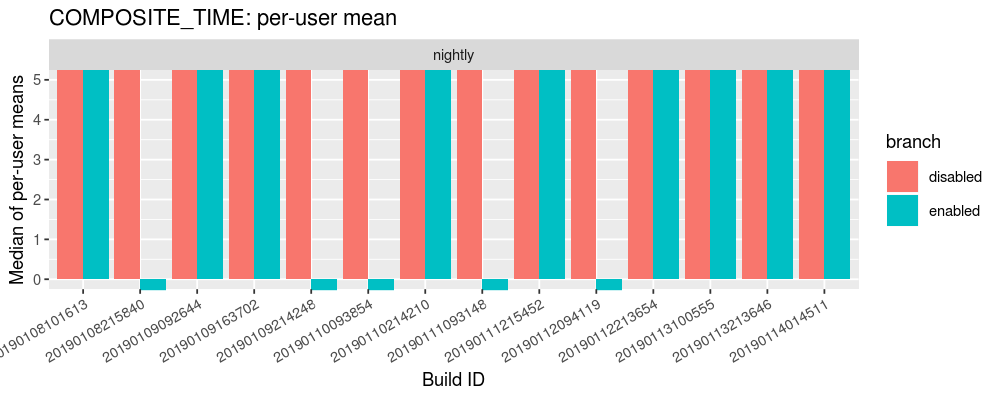

In [39]:
%r
perf_medians %>%
  inner_join(display_builds) %>%
  filter(metric=="composite_time") %>%
  ggplot(aes(app_build_id, user_median, ymin=10**log_ymin, ymax=10**log_ymax, fill=branch)) +
    facet_grid(~normalized_channel, scales="free_x", space="free_x") +
    geom_col(position=position_dodge()) +
    geom_errorbar(width=0.2, position=position_dodge(width=1)) +
    theme(axis.text.x=element_text(angle=30, hjust=1)) +
    coord_cartesian(ylim=c(0, 5)) +
    labs(title="COMPOSITE_TIME: per-user mean", x="Build ID", y="Median of per-user means")

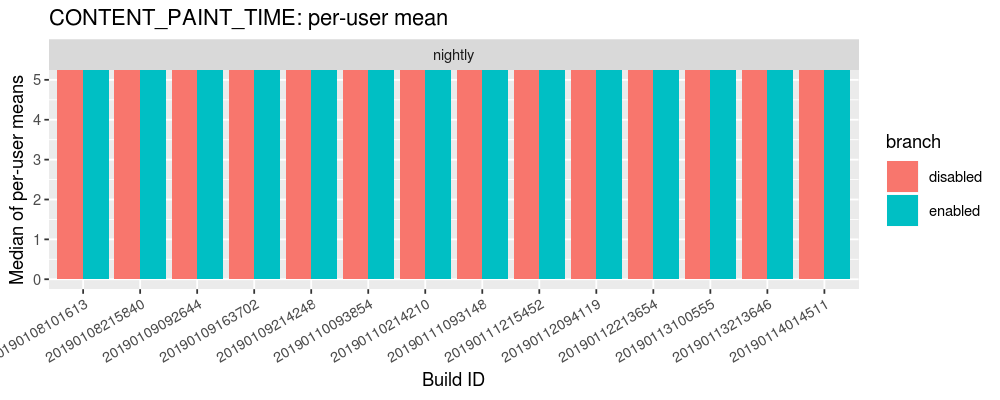

In [40]:
%r
perf_medians %>%
  inner_join(display_builds) %>%
  filter(metric=="content_paint_time") %>%
  ggplot(aes(app_build_id, user_median, ymin=10**log_ymin, ymax=10**log_ymax, fill=branch)) +
    facet_grid(~normalized_channel, scales="free_x", space="free_x") +
    geom_col(position=position_dodge()) +
    geom_errorbar(width=0.2, position=position_dodge(width=1)) +
    theme(axis.text.x=element_text(angle=30, hjust=1)) +
    coord_cartesian(ylim=c(0, 5)) +
    labs(title="CONTENT_PAINT_TIME: per-user mean", x="Build ID", y="Median of per-user means")

In [41]:
%r
paint_time_quantiles = tbl(sc, "global_temp.wr_paint_time_quantiles") %>%
  collect %>%
  group_by(app_build_id, normalized_channel, branch, quantile) %>%
  summarize(
    user_median=median(value, na.rm=TRUE),
    log_sd=sd(log10(value+1), na.rm=TRUE),
    log_sem=log_sd/sqrt(n()),
    log_ymin=log10(user_median)-1.96*log_sem,
    log_ymax=log10(user_median)+1.96*log_sem
  )

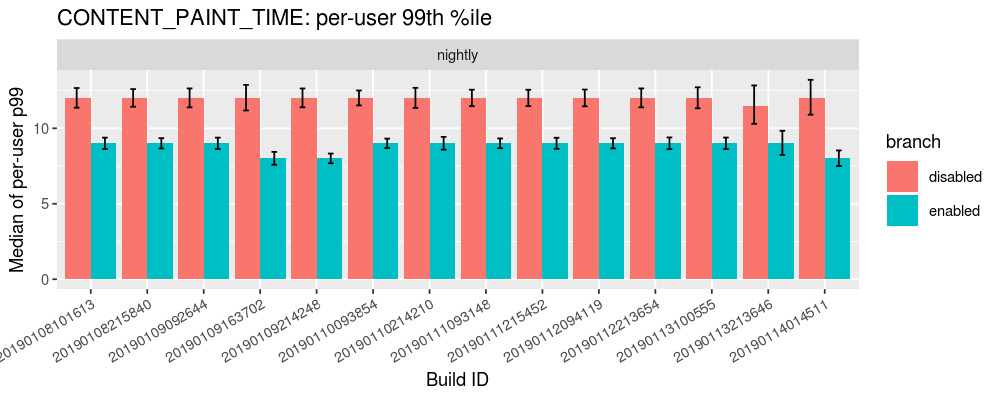

In [42]:
%r
paint_time_quantiles %>%
  inner_join(display_builds) %>%
  filter(quantile == 0.99) %>%
  ggplot(aes(app_build_id, user_median, ymin=10**log_ymin, ymax=10**log_ymax, fill=branch)) +
    facet_grid(~normalized_channel, scales="free_x", space="free_x") +
    geom_col(position=position_dodge()) +
    geom_errorbar(width=0.2, position=position_dodge(width=1)) +
    theme(axis.text.x=element_text(angle=30, hjust=1)) +
    labs(title="CONTENT_PAINT_TIME: per-user 99th %ile", x="Build ID", y="Median of per-user p99")

In [43]:
%r
perf_medians %>% filter(metric=='content_frame_time')

# A tibble: 48 x 9
# Groups: app_build_id, normalized_channel, branch [48]
 app_build_id normalized_chan… branch metric user_median log_sd log_sem
 
 1 20190104093… nightly disab… conte… 21396980 0.985 0.171 
 2 20190104093… nightly enabl… conte… 11695032. 1.11 0.168 
 3 20190104132… nightly disab… conte… 2446040 0.980 0.0554
 4 20190104132… nightly enabl… conte… 2691387 0.858 0.0470
 5 20190104214… nightly disab… conte… 2907514 0.959 0.0450
 6 20190104214… nightly enabl… conte… 2422656. 0.899 0.0404
 7 20190105123… nightly disab… conte… 2620307 0.976 0.0510
 8 20190105123… nightly enabl… conte… 2425068 0.912 0.0467
 9 20190105215… nightly disab… conte… 2758362 0.923 0.0486
10 20190105215… nightly enabl… conte… 2033532 0.833 0.0426
# ... with 38 more rows, and 2 more variables: log_ymin , log_ymax

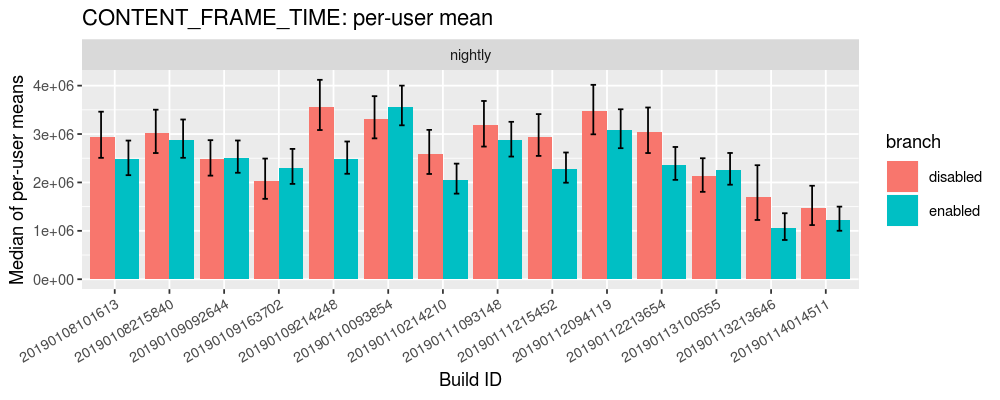

In [44]:
%r
perf_medians %>%
  inner_join(display_builds) %>%
  filter(metric=="content_frame_time") %>%
  filter(normalized_channel=='nightly') %>%
  ggplot(aes(app_build_id, user_median, ymin=10**log_ymin, ymax=10**log_ymax, fill=branch)) +
    facet_grid(~normalized_channel, scales="free_x", space="free_x") +
    geom_col(position=position_dodge()) +
    geom_errorbar(width=0.2, position=position_dodge(width=1)) +
    theme(axis.text.x=element_text(angle=30, hjust=1)) +
    #coord_cartesian(ylim=c(0, 10000000)) +
    labs(title="CONTENT_FRAME_TIME: per-user mean", x="Build ID", y="Median of per-user means")

In [45]:
%r
perf_medians %>%
  filter(app_build_id=='20190107214730') %>%
  inner_join(display_builds) %>%
  filter(metric=="content_frame_time_svg") %>%
  ggplot(aes(1, user_median, ymin=10**log_ymin, ymax=10**log_ymax, fill=branch)) +
    facet_grid(~normalized_channel, scales="free_x", space="free_x") +
    geom_col(position=position_dodge()) +
    geom_errorbar(width=0.2, position=position_dodge(width=1)) +
    theme(axis.text.x=element_text(angle=30, hjust=1)) +
    coord_cartesian(ylim=c(0, 200)) +
    labs(title="CONTENT_FRAME_TIME_SVG: per-user mean", x="Build ID", y="Median of per-user means")

Joining, by = c("app_build_id", "normalized_channel")
Error : Faceting variables must have at least one value
In addition: There were 14 warnings (use warnings() to see them)

In [46]:
%r
slow_content_frame_time = tbl(sc, "global_temp.wr_slow_content_frame_time") %>% collect

In [47]:
%r
slow_content_frame_boot = function(df) {
  ci = boot(df$fraction_exceeding, function(data, x) median(data[x], na.rm=TRUE), 1000) %>%
     boot.ci(0.95, "basic")
  data.frame(
    ymin=ci$basic[4],
    y=ci$t0,
    ymax=ci$basic[5]
  ) * 100
}

slow_content_frame_time_summary = slow_content_frame_time %>%
  group_by(normalized_channel, app_build_id, branch) %>%
  do(slow_content_frame_boot(.))

In [48]:
%r
# Thresholded slow events
# "composite_time", "content_paint_time", "content_full_paint_time"
slow_content_frame_time_svg_summary = tbl(sc, "global_temp.wr_slow_content_frame_time_svg") %>%
  collect %>%
  group_by(normalized_channel, app_build_id, branch) %>%
  do(slow_content_frame_boot(.))

slow_content_frame_time_svg_daily_summary = tbl(sc, "global_temp.wr_slow_content_frame_time_svg") %>%
  mutate(app_build_day = substr(app_build_id, 0, 8)) %>%
  collect %>%
  group_by(normalized_channel, app_build_day, branch) %>%
  do(slow_content_frame_boot(.))

[1] "All values of t are equal to 0.0223157894736842 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.0199264183674657 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.0223157894736842 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.0199264183674657 \n Cannot calculate confidence intervals"

In [49]:
%r
# Thresholded slow events
# "composite_time", "content_paint_time", "content_full_paint_time"
slow_content_frame_time_without_upload_summary = tbl(sc, "global_temp.wr_slow_content_frame_time_without_upload") %>%
  collect %>%
  group_by(normalized_channel, app_build_id, branch) %>%
  do(slow_content_frame_boot(.))

[1] "All values of t are equal to 0.0223157894736842 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.0203656028419796 \n Cannot calculate confidence intervals"

In [50]:
%r
# Thresholded slow events
# "composite_time", "content_paint_time", "content_full_paint_time"
slow_composite_time_summary = tbl(sc, "global_temp.wr_slow_composite_time") %>%
  collect %>%
  group_by(normalized_channel, app_build_id, branch) %>%
  do(slow_content_frame_boot(.))

In [51]:
%r
slow_content_paint_time_summary = tbl(sc, "global_temp.wr_slow_content_paint_time") %>%
  collect %>%
  group_by(normalized_channel, app_build_id, branch) %>%
  do(slow_content_frame_boot(.))

In [52]:
%r
slow_content_full_paint_time_summary = tbl(sc, "global_temp.wr_slow_content_full_paint_time") %>%
  collect %>%
  group_by(normalized_channel, app_build_id, branch) %>%
  do(slow_content_frame_boot(.))

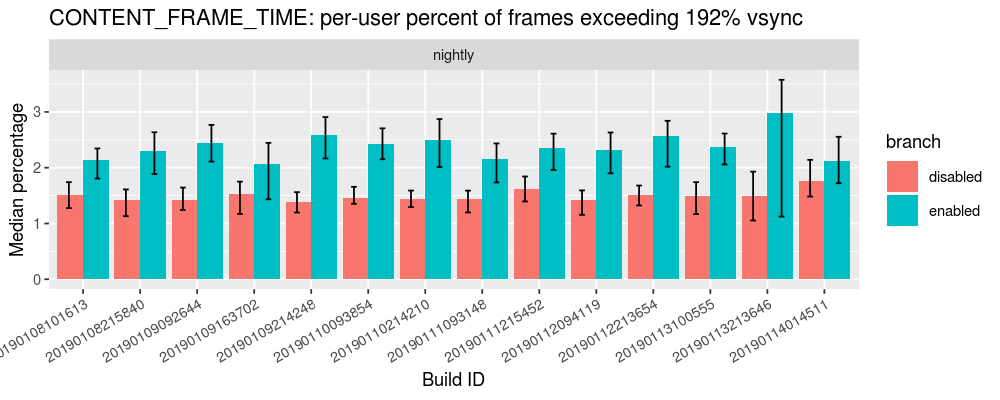

In [53]:
%r
slow_content_frame_time_summary %>%
  inner_join(display_builds) %>%
  ggplot(aes(app_build_id, y, ymin=ymin, ymax=ymax, fill=branch)) +
    facet_grid(~normalized_channel, scales="free_x", space="free_x") +
    geom_col(position=position_dodge()) +
    geom_errorbar(width=0.2, position=position_dodge(width=1)) +
    theme(axis.text.x=element_text(angle=30, hjust=1)) +
    labs(title="CONTENT_FRAME_TIME: per-user percent of frames exceeding 192% vsync", x="Build ID", y="Median percentage")

In [54]:
%r
slow_content_frame_time_summary

# A tibble: 48 x 6
# Groups: normalized_channel, app_build_id, branch [48]
 normalized_channel app_build_id branch ymin y ymax
 
 1 nightly 20190104093221 disabled 0.942 1.57 2.15
 2 nightly 20190104093221 enabled 0.431 2.81 4.10
 3 nightly 20190104132412 disabled 1.64 1.90 2.21
 4 nightly 20190104132412 enabled 1.57 2.28 2.82
 5 nightly 20190104214806 disabled 1.25 1.53 1.76
 6 nightly 20190104214806 enabled 2.02 2.58 3.05
 7 nightly 20190105123739 disabled 1.20 1.55 1.81
 8 nightly 20190105123739 enabled 1.80 2.38 2.79
 9 nightly 20190105215256 disabled 1.30 1.53 1.77
10 nightly 20190105215256 enabled 1.45 2.27 2.62
# ... with 38 more rows

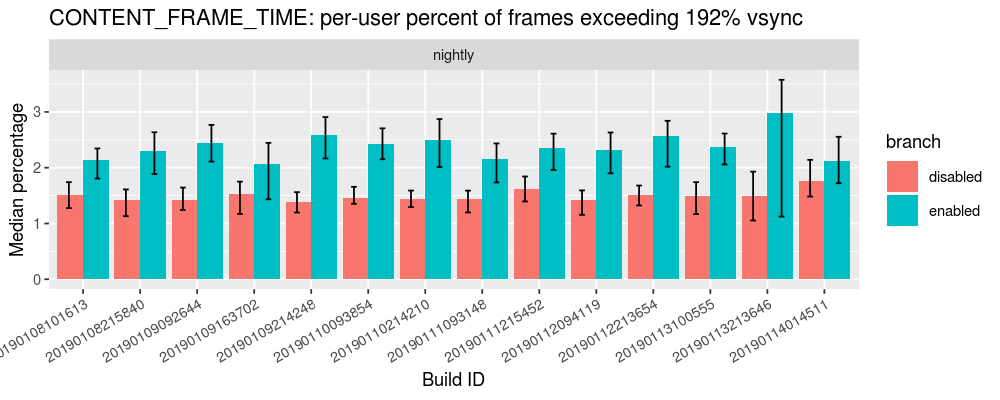

In [55]:
%r
slow_content_frame_time_summary %>%
  inner_join(display_builds) %>%
  filter(normalized_channel=="nightly") %>%
  ggplot(aes(app_build_id, y, ymin=ymin, ymax=ymax, fill=branch)) +
    facet_grid(~normalized_channel, scales="free_x", space="free_x") +
    geom_col(position=position_dodge()) +
    geom_errorbar(width=0.2, position=position_dodge(width=1)) +
    theme(axis.text.x=element_text(angle=30, hjust=1)) +
    labs(title="CONTENT_FRAME_TIME: per-user percent of frames exceeding 192% vsync", x="Build ID", y="Median percentage")

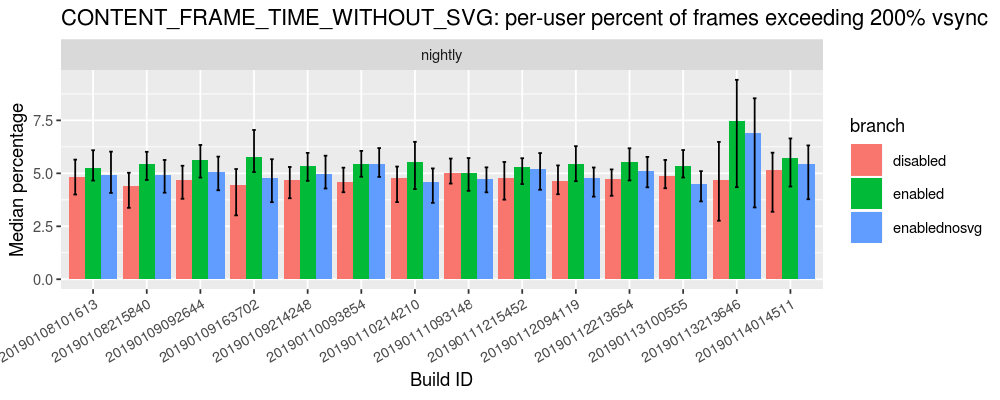

In [56]:
%r
slow_content_frame_time_svg_summary %>%
  inner_join(display_builds) %>%
  ggplot(aes(app_build_id, y, ymin=ymin, ymax=ymax, fill=branch)) +
    facet_grid(~normalized_channel, scales="free_x", space="free_x") +
    geom_col(position=position_dodge()) +
    geom_errorbar(width=0.2, position=position_dodge(width=1)) +
    theme(axis.text.x=element_text(angle=30, hjust=1)) +
    labs(title="CONTENT_FRAME_TIME_WITHOUT_SVG: per-user percent of frames exceeding 200% vsync", x="Build ID", y="Median percentage")

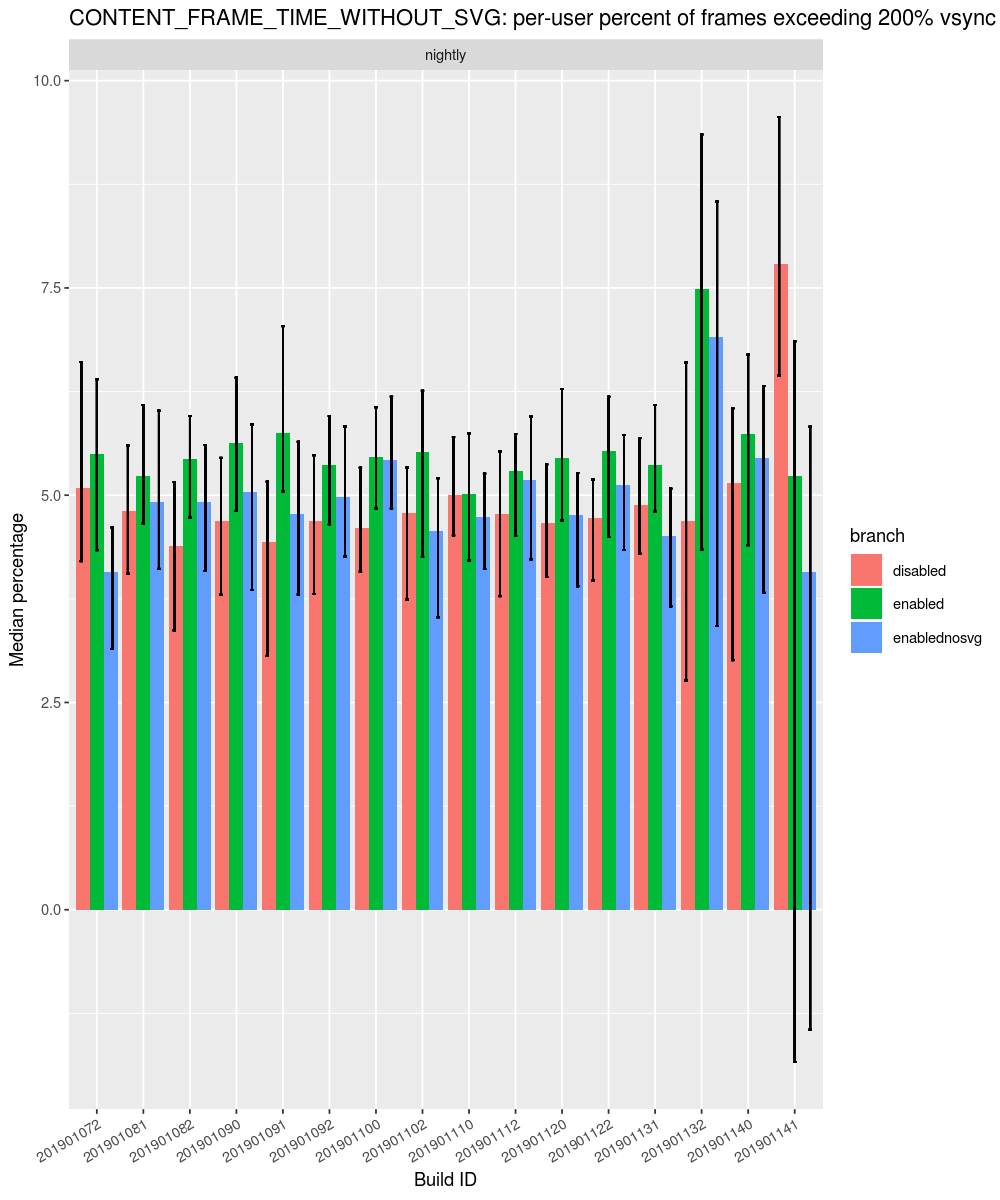

In [57]:
%r
slow_content_frame_time_svg_daily_summary %>%
  inner_join(display_builds) %>%
  ggplot(aes(app_build_day, y, ymin=ymin, ymax=ymax, fill=branch)) +
    facet_grid(~normalized_channel, scales="free_x", space="free_x") +
    geom_col(position=position_dodge()) +
    geom_errorbar(width=0.2, position=position_dodge(width=1)) +
    theme(axis.text.x=element_text(angle=30, hjust=1)) +
    labs(title="CONTENT_FRAME_TIME_WITHOUT_SVG: per-user percent of frames exceeding 200% vsync", x="Build ID", y="Median percentage")


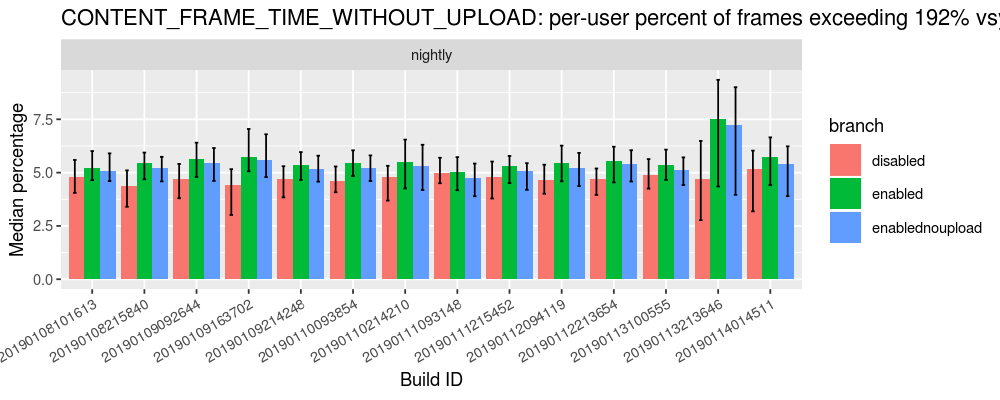

In [58]:
%r
slow_content_frame_time_without_upload_summary %>%
  inner_join(display_builds) %>%
  ggplot(aes(app_build_id, y, ymin=ymin, ymax=ymax, fill=branch)) +
    facet_grid(~normalized_channel, scales="free_x", space="free_x") +
    geom_col(position=position_dodge()) +
    geom_errorbar(width=0.2, position=position_dodge(width=1)) +
    theme(axis.text.x=element_text(angle=30, hjust=1)) +
    labs(title="CONTENT_FRAME_TIME_WITHOUT_UPLOAD: per-user percent of frames exceeding 192% vsync", x="Build ID", y="Median percentage")

In [59]:
%r
slow_content_frame_boot_p90 = function(df) {
  ci = boot(df$fraction_exceeding, function(data, x) quantile(data[x], 0.9, na.rm=TRUE), 1000) %>%
     boot.ci(0.95, "basic")
  data.frame(
    ymin=ci$basic[4],
    y=ci$t0,
    ymax=ci$basic[5]
  ) * 100
}

slow_content_frame_time_summary_p90 = slow_content_frame_time %>%
  group_by(normalized_channel, app_build_id, branch) %>%
  do(slow_content_frame_boot_p90(.))

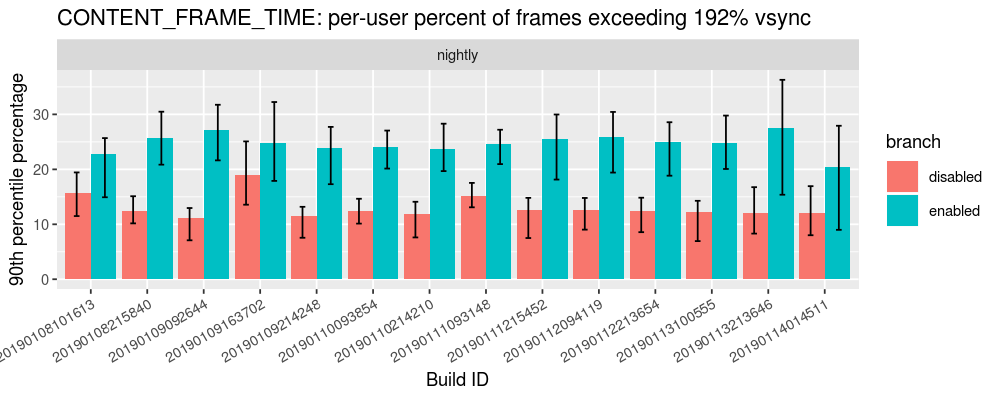

In [60]:
%r
slow_content_frame_time_summary_p90 %>%
  inner_join(display_builds) %>%
  ggplot(aes(app_build_id, y, ymin=ymin, ymax=ymax, fill=branch)) +
    facet_grid(~normalized_channel, scales="free_x", space="free_x") +
    geom_col(position=position_dodge()) +
    geom_errorbar(width=0.2, position=position_dodge(width=1)) +
    theme(axis.text.x=element_text(angle=30, hjust=1)) +
    labs(title="CONTENT_FRAME_TIME: per-user percent of frames exceeding 192% vsync", x="Build ID", y="90th percentile percentage")

In [61]:
%r
perf_medians %>%
  inner_join(display_builds) %>%
  filter(metric=="tab_switch_composite") %>%
  ggplot(aes(app_build_id, user_median, ymin=10**log_ymin, ymax=10**log_ymax, fill=branch)) +
    facet_grid(~normalized_channel, scales="free_x", space="free_x") +
    geom_col(position=position_dodge()) +
    geom_errorbar(width=0.2, position=position_dodge(width=1)) +
    theme(axis.text.x=element_text(angle=30, hjust=1)) +
    labs(title="FX_TAB_SWITCH_COMPOSITE_E10S_MS: per-user mean", x="Build ID", y="Median of per-user means")